## IMPORT

In [1]:
!pip install timm torchmetrics seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import timm  # required for CTransPath
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [5]:
# --------------------------
# DEVICE + SEED
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

Device: cuda


## DATASET

In [6]:
!ls -R /kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria

/kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria:
100X  200X  400X  40X

/kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria/100X:
benign	malignant

/kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria/100X/benign:
SOB_B_A-14-22549AB-100-001.png	SOB_B_F-14-29960AB-100-001.png
SOB_B_A-14-22549AB-100-002.png	SOB_B_F-14-29960AB-100-002.png
SOB_B_A-14-22549AB-100-003.png	SOB_B_F-14-29960AB-100-003.png
SOB_B_A-14-22549AB-100-004.png	SOB_B_F-14-29960AB-100-004.png
SOB_B_A-14-22549AB-100-005.png	SOB_B_F-14-29960AB-100-005.png
SOB_B_A-14-22549AB-100-006.png	SOB_B_F-14-29960AB-100-006.png
SOB_B_A-14-22549AB-100-007.png	SOB_B_F-14-29960AB-100-007.png
SOB_B_A-14-22549AB-100-008.png	SOB_B_F-14-29960AB-100-008.png
SOB_B_A-14-22549AB-100-009.png	SOB_B_F-14-29960AB-100-009.png
SOB_B_A-14-22549AB-100-010.png	SOB_B_F-14-29960AB-100-010.png
SOB_B_A-14-22549AB-100-011.png	SOB_B_F-14-29960AB-100-011.png
SOB_B_A-14-22549AB-100-012.png	SOB_B_F-14-29960AB-100-01

In [7]:
BREAKHIS_PATH = "/kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria"
WORK_DIR = "/kaggle/working"

CSV_BH_TRAIN = f"{WORK_DIR}/breakhis_train.csv"
CSV_BH_VAL   = f"{WORK_DIR}/breakhis_val.csv"
CSV_BH_TEST  = f"{WORK_DIR}/breakhis_test.csv"

print("BreakHis path:", BREAKHIS_PATH)
print("Work dir:", WORK_DIR)

BreakHis path: /kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria
Work dir: /kaggle/working


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# static counts based on pdf
data_mag = {
    "magnification": ["40X", "100X", "200X", "400X"],
    "benign": [248, 348, 273, 304],
    "malignant": [625, 675, 780, 812]
}

df_mag = pd.DataFrame(data_mag)
df_mag["total"] = df_mag["benign"] + df_mag["malignant"]

print(df_mag)

  magnification  benign  malignant  total
0           40X     248        625    873
1          100X     348        675   1023
2          200X     273        780   1053
3          400X     304        812   1116


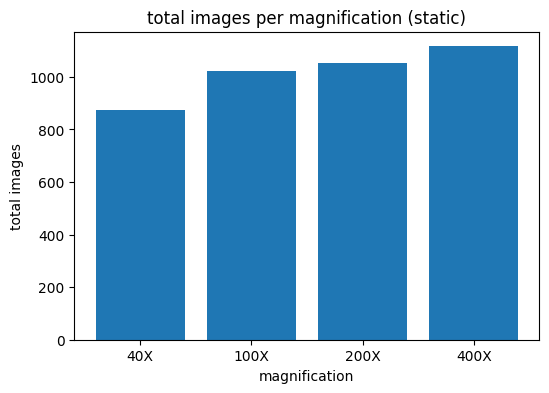

In [14]:
# bar chart: total per magnification
plt.figure(figsize=(6,4))
plt.bar(df_mag["magnification"], df_mag["total"])
plt.xlabel("magnification")
plt.ylabel("total images")
plt.title("total images per magnification (static)")
plt.show()

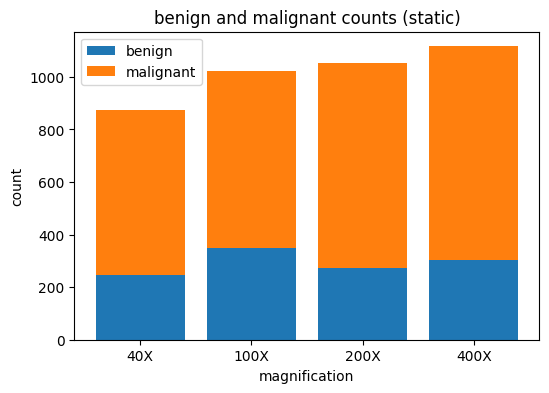

In [15]:
# bar chart: benign vs malignant per magnification
plt.figure(figsize=(6,4))
x = range(len(df_mag))
plt.bar(x, df_mag["benign"], label="benign")
plt.bar(x, df_mag["malignant"], bottom=df_mag["benign"], label="malignant")
plt.xticks(x, df_mag["magnification"])
plt.xlabel("magnification")
plt.ylabel("count")
plt.title("benign and malignant counts (static)")
plt.legend()
plt.show()

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

root = "/kaggle/input/cancer/Cancer_Dataset/BreakHis/classificacao_binaria"

magnifications = ["40X", "100X", "200X", "400X"]
classes = ["benign", "malignant"]

rows = []

for mag in magnifications:
    mag_path = os.path.join(root, mag)
    if not os.path.isdir(mag_path):
        continue
    for cls in classes:
        cls_path = os.path.join(mag_path, cls)
        if not os.path.isdir(cls_path):
            continue
        count = sum(len(files) for _, _, files in os.walk(cls_path))
        rows.append([mag, cls, count])

df = pd.DataFrame(rows, columns=["magnification", "class", "count"])
print(df)

# table pivot
df_pivot = df.pivot(index="magnification", columns="class", values="count").fillna(0).astype(int)
df_pivot["total"] = df_pivot.sum(axis=1)

print(df_pivot)

  magnification      class  count
0           40X     benign    625
1           40X  malignant   1370
2          100X     benign    644
3          100X  malignant   1437
4          200X     benign    623
5          200X  malignant   1390
6          400X     benign    588
7          400X  malignant   1232
class          benign  malignant  total
magnification                          
100X              644       1437   2081
200X              623       1390   2013
400X              588       1232   1820
40X               625       1370   1995


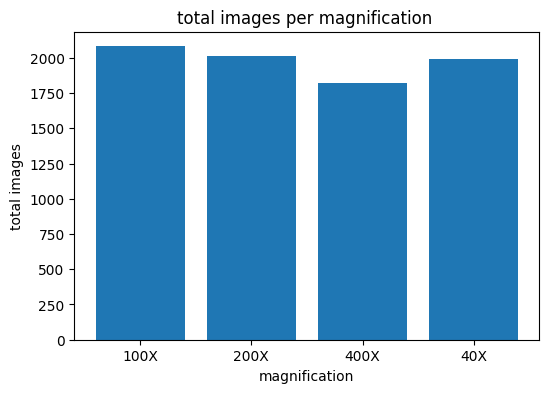

In [19]:

# bar chart: total per magnification
plt.figure(figsize=(6,4))
plt.bar(df_pivot.index, df_pivot["total"])
plt.xlabel("magnification")
plt.ylabel("total images")
plt.title("total images per magnification ")
plt.show()

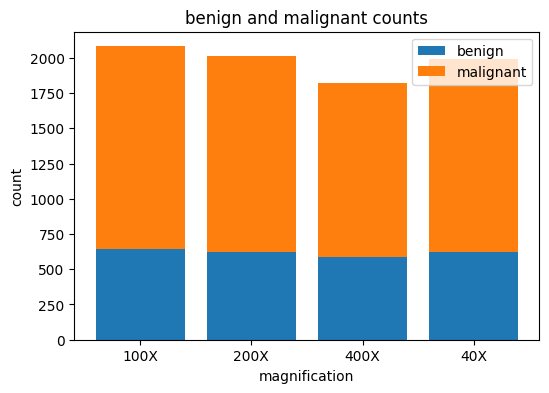

In [20]:

# bar chart: benign vs malignant
plt.figure(figsize=(6,4))
plt.bar(df_pivot.index, df_pivot["benign"], label="benign")
plt.bar(df_pivot.index, df_pivot["malignant"], bottom=df_pivot["benign"], label="malignant")
plt.xlabel("magnification")
plt.ylabel("count")
plt.title("benign and malignant counts")
plt.legend()
plt.show()


In [22]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# assuming BREAKHIS_PATH, WORK_DIR, SEED, and the CSV paths are already defined

mag_list = ["40X", "100X", "200X", "400X"]
class_map = {"benign": 0, "malignant": 1}

rows = []

for mag in mag_list:
    mag_path = os.path.join(BREAKHIS_PATH, mag)
    if not os.path.isdir(mag_path):
        continue
    for cls_name, cls_label in class_map.items():
        cls_path = os.path.join(mag_path, cls_name)
        if not os.path.isdir(cls_path):
            continue
        for root_dir, _, files in os.walk(cls_path):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif")):
                    full_path = os.path.join(root_dir, f)
                    rows.append({
                        "path": full_path,
                        "label": cls_label,
                        "magnification": mag,
                        "classname": cls_name
                    })

df_all = pd.DataFrame(rows)
df_all = df_all.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("total images in breakhis:", len(df_all))
print(df_all.head())

total images in breakhis: 7909
                                                path  label magnification  \
0  /kaggle/input/cancer/Cancer_Dataset/BreakHis/c...      1          100X   
1  /kaggle/input/cancer/Cancer_Dataset/BreakHis/c...      1          200X   
2  /kaggle/input/cancer/Cancer_Dataset/BreakHis/c...      0          200X   
3  /kaggle/input/cancer/Cancer_Dataset/BreakHis/c...      1          100X   
4  /kaggle/input/cancer/Cancer_Dataset/BreakHis/c...      1          100X   

   classname  
0  malignant  
1  malignant  
2     benign  
3  malignant  
4  malignant  


In [23]:
print(df_all["label"].value_counts())
print(df_all["magnification"].value_counts())
print(df_all.groupby(["magnification", "classname"]).size())


label
1    5429
0    2480
Name: count, dtype: int64
magnification
100X    2081
200X    2013
40X     1995
400X    1820
Name: count, dtype: int64
magnification  classname
100X           benign        644
               malignant    1437
200X           benign        623
               malignant    1390
400X           benign        588
               malignant    1232
40X            benign        625
               malignant    1370
dtype: int64


In [24]:
# 70% train, 15% val, 15% test
df_train, df_temp = train_test_split(
    df_all,
    test_size=0.30,
    random_state=SEED,
    stratify=df_all["label"]
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=df_temp["label"]
)

print("train samples:", len(df_train))
print("val samples:", len(df_val))
print("test samples:", len(df_test))

df_train.to_csv(CSV_BH_TRAIN, index=False)
df_val.to_csv(CSV_BH_VAL, index=False)
df_test.to_csv(CSV_BH_TEST, index=False)

print("saved:")
print(CSV_BH_TRAIN)
print(CSV_BH_VAL)
print(CSV_BH_TEST)


train samples: 5536
val samples: 1186
test samples: 1187
saved:
/kaggle/working/breakhis_train.csv
/kaggle/working/breakhis_val.csv
/kaggle/working/breakhis_test.csv


In [27]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# map magnification string to index
mag_to_idx = {"40X": 0, "100X": 1, "200X": 2, "400X": 3}

class BreakHisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label = int(row["label"])
        mag = row["magnification"]
        mag_idx = mag_to_idx.get(mag, -1)

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        sample = {
            "image": img,
            "label": torch.tensor(label, dtype=torch.long),
            "mag_idx": torch.tensor(mag_idx, dtype=torch.long),
            "path": img_path
        }
        return sample

# image size for ctranspath (usually 224 or 256; start with 224)
img_size = 224

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# datasets
train_ds = BreakHisDataset(df_train, transform=train_transform)
val_ds = BreakHisDataset(df_val, transform=val_test_transform)
test_ds = BreakHisDataset(df_test, transform=val_test_transform)

print("train samples:", len(train_ds))
print("val samples:", len(val_ds))
print("test samples:", len(test_ds))

# dataloaders
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

print("train batches:", len(train_loader))
print("val batches:", len(val_loader))
print("test batches:", len(test_loader))

train samples: 5536
val samples: 1186
test samples: 1187
train batches: 173
val batches: 38
test batches: 38


In [28]:
# quick sanity check
batch = next(iter(train_loader))
print("batch image shape:", batch["image"].shape)
print("batch label shape:", batch["label"].shape)
print("batch mag_idx shape:", batch["mag_idx"].shape)
print("first few labels:", batch["label"][:8].tolist())
print("first few mag_idx:", batch["mag_idx"][:8].tolist())


batch image shape: torch.Size([32, 3, 224, 224])
batch label shape: torch.Size([32])
batch mag_idx shape: torch.Size([32])
first few labels: [1, 1, 0, 1, 1, 1, 0, 1]
first few mag_idx: [2, 1, 3, 3, 2, 3, 1, 0]


## MODEL

In [29]:
# =======================================
# Load CTransPath (TorchScript) + DINO
# =======================================

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [30]:
!apt-get install -y git-lfs
!git lfs install

# Clone CTransPath repo
!git clone https://huggingface.co/kaczmarj/CTransPath

# Copy TorchScript file to working directory
!cp CTransPath/torchscript_model.pt ./

print("CTransPath torchscript_model.pt downloaded successfully!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 165 not upgraded.
Git LFS initialized.
Cloning into 'CTransPath'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 27 (delta 3), reused 0 (delta 0), pack-reused 16 (from 1)
Unpacking objects: 100% (27/27), 7.98 KiB | 1.14 MiB/s, done.
Filtering content: 100% (4/4), 425.69 MiB | 189.61 MiB/s, done.
CTransPath torchscript_model.pt downloaded successfully!


In [31]:
# -------------------- Load CTransPath TorchScript --------------------
print("Loading CTransPath TorchScript model...")
ctrans = torch.jit.load("torchscript_model.pt")
ctrans.eval()

# Move to device
ctrans = ctrans.to(device)

# CTransPath feature dimension
ctrans_dim = 768  # TorchScript model outputs 768-dim CLS token
print("CTransPath loaded. Feature dim:", ctrans_dim)

Loading CTransPath TorchScript model...
CTransPath loaded. Feature dim: 768


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import os

class CTransClassifier(nn.Module):
    def __init__(self, backbone, feat_dim=768, num_classes=2, train_backbone=False):
        super().__init__()
        self.backbone = backbone
        self.train_backbone = train_backbone

        if not train_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # simple classifier head on top of 768-d features
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # backbone is torchscript; it should output features of size (b, feat_dim)
        with torch.set_grad_enabled(self.train_backbone):
            feats = self.backbone(x)  # expected shape: (b, 768)
        logits = self.head(feats)
        return logits

In [33]:
# create model instance
model = CTransClassifier(ctrans, feat_dim=ctrans_dim, num_classes=2, train_backbone=False)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

print("Device of model:", device)

Device of model: cuda


## TRAINING

In [34]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

def compute_metrics(y_true, y_pred):
    m = {}
    m["acc"] = accuracy_score(y_true, y_pred)
    m["f1_macro"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    m["f1_micro"] = f1_score(y_true, y_pred, average="micro", zero_division=0)
    m["jaccard_macro"] = jaccard_score(y_true, y_pred, average="macro", zero_division=0)
    m["jaccard_micro"] = jaccard_score(y_true, y_pred, average="micro", zero_division=0)
    return m

In [35]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        labs = labels.detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labs)

    epoch_loss = running_loss / len(loader.dataset)
    metrics = compute_metrics(all_labels, all_preds)
    return epoch_loss, metrics


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            labs = labels.detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labs)

    epoch_loss = running_loss / len(loader.dataset)
    metrics = compute_metrics(all_labels, all_preds)
    return epoch_loss, metrics

In [36]:
num_epochs = 30          
patience = 5            

best_val_acc = 0.0
best_epoch = -1
best_val_loss = None
best_val_metrics = None
best_model_path = os.path.join(WORK_DIR, "ctranspath_breakhis_best.pth")

epochs_without_improvement = 0

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

for epoch in range(1, num_epochs + 1):
    train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_metrics = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_metrics["acc"])

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"epoch {epoch}")
    print(f"  train: loss={train_loss:.4f}, "
          f"acc={train_metrics['acc']:.4f}, "
          f"f1_macro={train_metrics['f1_macro']:.4f}, "
          f"f1_micro={train_metrics['f1_micro']:.4f}, "
          f"jaccard_macro={train_metrics['jaccard_macro']:.4f}, "
          f"jaccard_micro={train_metrics['jaccard_micro']:.4f}")
    print(f"  val:   loss={val_loss:.4f}, "
          f"acc={val_metrics['acc']:.4f}, "
          f"f1_macro={val_metrics['f1_macro']:.4f}, "
          f"f1_micro={val_metrics['f1_micro']:.4f}, "
          f"jaccard_macro={val_metrics['jaccard_macro']:.4f}, "
          f"jaccard_micro={val_metrics['jaccard_micro']:.4f}")

    if val_metrics["acc"] > best_val_acc:
        best_val_acc = val_metrics["acc"]
        best_epoch = epoch
        best_val_loss = val_loss
        best_val_metrics = val_metrics.copy()
        torch.save(model.state_dict(), best_model_path)
        print("  new best model saved with val_acc:", best_val_acc)
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print("  no improvement for", epochs_without_improvement, "epoch(s)")

    if epochs_without_improvement >= patience:
        print("early stopping triggered at epoch", epoch)
        break

print("best validation accuracy:", best_val_acc)
print("best model path:", best_model_path)

KeyboardInterrupt: 

## EVALUATION

In [ ]:
import time

training_start = time.time()

# -----------------------------------
# your training loop goes here
# -----------------------------------

training_end = time.time()
total_training_time = training_end - training_start
print("total training time (seconds):", total_training_time)

In [ ]:
def inference_time(model, loader, device):
    model.eval()
    start = time.time()

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            _ = model(images)

    end = time.time()
    total = end - start
    per_image = total / len(loader.dataset)
    return total, per_image

total_inf, per_image_inf = inference_time(model, test_loader, device)

print("total inference time (seconds):", total_inf)
print("inference time per image (seconds):", per_image_inf)

In [ ]:
epoch_times = []

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    # your epoch training + validation

    epoch_end = time.time()
    epoch_times.append(epoch_end - epoch_start)
    print("epoch", epoch, "time:", epoch_times[-1])

print("average epoch time:", sum(epoch_times) / len(epoch_times))

In [ ]:

# final epoch summary (last trained epoch)
last_epoch = history["epoch"][-1]
last_train_loss = history["train_loss"][-1]
last_val_loss = history["val_loss"][-1]
last_train_metrics = history["train_metrics"][-1]
last_val_metrics = history["val_metrics"][-1]

print("\nfinal epoch summary")
print(f"  epoch: {last_epoch}")
print(f"  train: loss={last_train_loss:.4f}, "
      f"acc={last_train_metrics['acc']:.4f}, "
      f"f1_macro={last_train_metrics['f1_macro']:.4f}, "
      f"f1_micro={last_train_metrics['f1_micro']:.4f}, "
      f"jaccard_macro={last_train_metrics['jaccard_macro']:.4f}, "
      f"jaccard_micro={last_train_metrics['jaccard_micro']:.4f}")
print(f"  val:   loss={last_val_loss:.4f}, "
      f"acc={last_val_metrics['acc']:.4f}, "
      f"f1_macro={last_val_metrics['f1_macro']:.4f}, "
      f"f1_micro={last_val_metrics['f1_micro']:.4f}, "
      f"jaccard_macro={last_val_metrics['jaccard_macro']:.4f}, "
      f"jaccard_micro={last_val_metrics['jaccard_micro']:.4f}")


In [ ]:

print("\nbest validation epoch summary")
print(f"  epoch: {best_epoch}")
print(f"  val:   loss={best_val_loss:.4f}, "
      f"acc={best_val_metrics['acc']:.4f}, "
      f"f1_macro={best_val_metrics['f1_macro']:.4f}, "
      f"f1_micro={best_val_metrics['f1_micro']:.4f}, "
      f"jaccard_macro={best_val_metrics['jaccard_macro']:.4f}, "
      f"jaccard_micro={best_val_metrics['jaccard_micro']:.4f})")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
import torch.nn.functional as F


In [ ]:
# accuracy curves

epochs = history["epoch"]
train_accs = [m["acc"] for m in history["train_metrics"]]
val_accs = [m["acc"] for m in history["val_metrics"]]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_accs, label="train acc")
plt.plot(epochs, val_accs, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("train and val accuracy")
plt.legend()
plt.grid(True)
plt.show()

# loss curves

train_losses = history["train_loss"]
val_losses = history["val_loss"]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train and val loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)              # logits [b, 2]
        probs = F.softmax(outputs, dim=1)    # probabilities [b, 2]

        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # prob of class 1 (malignant)

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_score = np.array(all_scores)

target_names = ["benign", "malignant"]
print("classification report (test set)")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Test set - confusion matrix")
print(cm)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("confusion matrix")
plt.show()


In [ ]:
# roc and auc for binary classification (class 1 = malignant)

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
auc_value = roc_auc_score(y_true, y_score)

print("roc auc (class 1 malignant):", auc_value)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"roc curve (auc = {auc_value:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("roc curve (test set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def print_model_complexity(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("total parameters:", total_params)
    print("trainable parameters:", trainable_params)
    
print_model_complexity(model)

In [ ]:
try:
    from ptflops import get_model_complexity_info

    def print_flops(model):
        with torch.cuda.device(0):
            macs, params = get_model_complexity_info(
                model,
                (3, 224, 224),
                as_strings=True,
                verbose=False
            )
        print("macs:", macs)
        print("params:", params)

    print_flops(model)

except Exception as e:
    print("flops estimation not available:", e)

In [ ]:
print("\nsummary")
print("best validation accuracy:", best_val_acc)
print("total training time (seconds):", total_training_time)
print("test Total inference time (seconds):", total_inf)
print("test inference time per image (seconds):", per_image_inf)